# []

In [1]:
# inbuilt 
import os
import sys
import math

# most common
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch as tt
import torch.nn as nn
import torch.functional as ff
import torch.distributions as dd
import torch.utils.data as ud

import random
import time
# custom
import known
import known.ktorch as kt
print(f'{sys.version=}\n{np.__version__=}\n{tt.__version__=}\n{known.__version__=}')

sys.version='3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]'
np.__version__='1.24.1'
tt.__version__='1.13.1+cpu'
known.__version__='0.0.1'


# Sample Data

In [2]:
# set seed
tt.manual_seed(281703975047300) # manually sets a seed for random sampling creation ops
print('Manual-Seed:', tt.initial_seed()) # current seed for default rng

batch_size = 64 
input_size = 10 
hidden_size = 32
seq_len = 15

dt=tt.float32
batch_first=False
dropout=0.0
num_layers = 10

num_samples=50
num_loops=10

xx = [tt.rand(size=(batch_size, seq_len, input_size), dtype=dt) for _ in range(num_samples)] \
            if batch_first else \
    [tt.rand(size=(seq_len, batch_size, input_size), dtype=dt) for _ in range(num_samples) ]
len(xx)

Manual-Seed: 281703975047300


50

# Pre-Built Cells

## Elman

In [ ]:
rnn_torch = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    nonlinearity='tanh',
    batch_first=batch_first,
    num_layers=num_layers,
    dropout=dropout,
    dtype=dt
)
rnn = kt.ELMAN(
    input_bias=True,
    hidden_bias=True,
    actF=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False
)

rnnc = kt.ELMANC(
    has_bias=True,
    actF=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False)


## GRU

In [ ]:
rnn_torch = nn.GRU(
    input_size=input_size,
    hidden_size=hidden_size,
    #nonlinearity='tanh',
    batch_first=batch_first,
    num_layers=num_layers,
    dropout=dropout,
    dtype=dt
)
rnn = kt.GRU(
    input_bias=True,
    hidden_bias=True,
    actF=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False
)

rnnc = kt.GRUC(
    has_bias=True,
    actF=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False
)



## LSTM

In [3]:
rnn_torch = nn.LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    #nonlinearity='tanh',
    batch_first=batch_first,
    num_layers=num_layers,
    dropout=dropout,
    dtype=dt
)
rnn = kt.LSTM(
    input_bias=True,
    hidden_bias=True,
    actF=tt.tanh, actC=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False
)

rnnc = kt.LSTMC(
    has_bias=True,
    actF=tt.tanh, actC=tt.tanh,
    input_size=input_size,         # input features
    hidden_sizes=[hidden_size for _ in range(num_layers)],       # hidden features at each layer
    dropout=dropout,        # dropout after each layer, only if hidden_sizes > 1
    batch_first=batch_first,  # if true, excepts input as (batch_size, seq_len, input_size) else (seq_len, batch_size, input_size)
    dtype=dt,
    device=None,
    stack_output=False
)

## Genralized RNN

In [4]:
rnng = kt.GRNN(
    core = kt.clone_model(rnn))

## copy weights

In [5]:
#known.ktorch.show_parameters(rnn_torch)
#known.ktorch.show_parameters(rnn)
#known.ktorch.show_parameters(rnn_stack)
#known.ktorch.show_parameters(stacked_rnn)

rnn.copy_torch(rnn_torch)
rnng.core.copy_torch(rnn_torch)

for i,weight_diff in enumerate([rnn.diff_torch(rnn_torch),  rnng.core.diff_torch(rnn_torch),]):
    sum_wd = 0
    for l in weight_diff:
        sum_wd+=tt.sum(tt.abs(l))
    print(i,sum_wd)

0 tensor(0.)
1 tensor(0.)


## compar outputs

In [7]:
def absdiff(y, Y):
    s=0
    for yi,yit in zip(y, Y):
        assert (yi.shape == yit.shape)
        s+= (tt.sum(tt.abs(yi-yit)).item())
    return s, np.mean(s)

In [ ]:
# for single o/p cell
xi = random.randint(0, len(xx)-1)
x=xx[xi]
with tt.no_grad():
    Y, H = rnn_torch(x)
    for y,h in [rnn(x),rnng(x), rnnc(x)]:
        print(Y.shape, H.shape)
        print(len(y), len(h[0]))
        print(absdiff(y,Y))


In [8]:
# for single o/p cell
xi = random.randint(0, len(xx)-1)
x=xx[xi]
with tt.no_grad():
    Y, (H, C) = rnn_torch(x)
    for y,h in [rnn(x), rnng(x), rnnc(x)]:
        print(Y.shape, H.shape)
        print(len(y), len(h[0]), len(h[1]))
        print(absdiff(y,Y))
        print(absdiff(h[0],H))
        print(absdiff(h[1],C))

torch.Size([15, 64, 32]) torch.Size([10, 64, 32])
15 10 10
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
torch.Size([15, 64, 32]) torch.Size([10, 64, 32])
15 10 10
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
torch.Size([15, 64, 32]) torch.Size([10, 64, 32])
15 10 10
(6811.410537719727, 6811.410537719727)
(4673.006866455078, 4673.006866455078)
(10215.087524414062, 10215.087524414062)


## compar time

In [9]:
eta_torch = []

for _ in range(num_loops):
    start_at = time.time()
    for x in xx: _ = rnn_torch(x)
    end_at = time.time()
    eta_torch.append(end_at-start_at)
    
print(np.mean(eta_torch), np.sum(eta_torch))

1.3526360750198365 13.526360750198364


In [10]:
eta_inherit = []

for _ in range(num_loops):
    start_at = time.time()
    for x in xx: _ = rnn(x)
    end_at = time.time()
    eta_inherit.append(end_at-start_at)
    
print(np.mean(eta_inherit), np.sum(eta_inherit))

2.9115698099136353 29.115698099136353


In [11]:
eta_gen = []

for _ in range(num_loops):
    start_at = time.time()
    for x in xx: _ = rnng(x)
    end_at = time.time()
    eta_gen.append(end_at-start_at)
    
print(np.mean(eta_gen), np.sum(eta_gen))

2.916599917411804 29.165999174118042


In [12]:
eta_comb = []

for _ in range(num_loops):
    start_at = time.time()
    for x in xx: _ = rnnc(x)
    end_at = time.time()
    eta_comb.append(end_at-start_at)
    
print(np.mean(eta_comb), np.sum(eta_comb))

2.3112311601638793 23.112311601638794


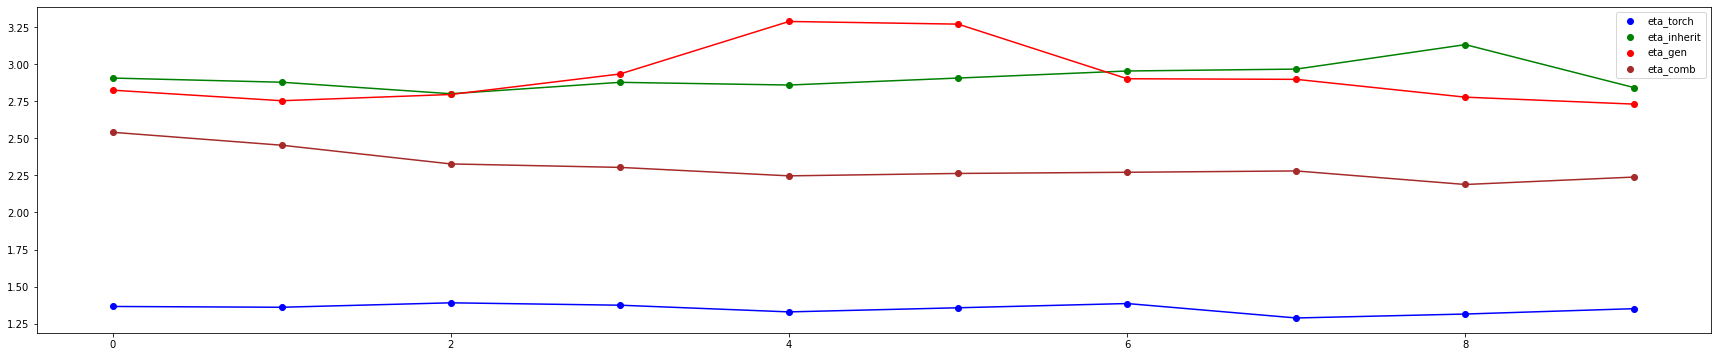

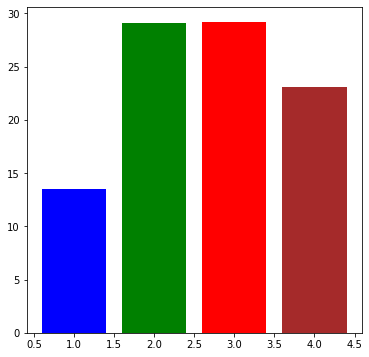

In [13]:
plt.figure(figsize=(30,6))

xr = np.arange(num_loops)
plt.scatter(xr, eta_torch, label='eta_torch', color='blue' )
plt.scatter(xr, eta_inherit, label='eta_inherit' , color='green')
plt.scatter(xr, eta_gen, label='eta_gen' , color='red')
plt.scatter(xr, eta_comb, label='eta_comb' , color='brown')

plt.plot(xr, eta_torch , color='blue')
plt.plot(xr, eta_inherit , color='green')
plt.plot(xr, eta_gen , color='red')
plt.plot(xr, eta_comb , color='brown')

plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.bar([1], [np.sum(eta_torch)], color='blue')
plt.bar([2], [np.sum(eta_inherit)], color='green')
plt.bar([3], [np.sum(eta_gen)], color='red')
plt.bar([4], [np.sum(eta_comb)], color='brown')

plt.show()